# Histogram Oriented Gradient

Let's talk a little bit about HOG and some of the main pointers-
- The HOG descriptor focuses on the structure or the shape of an object. Now you might ask, how is this different from the edge features we extract for images? In the case of edge features, we only identify if the pixel is an edge or not. HOG is able to provide the edge direction as well. This is done by extracting the gradient and orientation (or you can say magnitude and direction) of the edges.
- Additionally, these orientations are calculated in ‘localized’ portions. This means that the complete image is broken down into smaller regions and for each region, the gradients and orientation are calculated. We will discuss this in much more detail in the upcoming sections.
- Finally the HOG would generate a Histogram for each of these regions separately. The histograms are created using the gradients and orientations of the pixel values, hence the name ‘Histogram of Oriented Gradients’.


**Method of extracting the features using HOG**:
1. Preprocess the Data
2. Calculate Gradients
3. Calculate the Magnitude and Orientation
4. Create Histogram using Gradients and Orientations
5. Calculate Histogram of Gradients
6. Normalize the Gradients

Lets dicuss each step in more detail:

1. **Preprocess the Data:** After opening the image. Convert it into gray scale image and make sure that it is resized into the expected dimension. In the original paper, they used 128X64 dimension but here given the images are of vehicles I will take 64X128 dimension. After converting it into numpy array, also make sure to convert the array into float32 type otherwise overflow may happen.

2. **Calculate Gradients:** Gradient means small changes in the x-direction and y-direction. For an image gradient of a pixel would be the difference between it's previous pixel and next pixel. Horizontally it will be G_x(r, c) = I(r, c+1) - I(r, c-1) and vertically G_y = I(r+1, c) - I(r-2, c) where I(r, c) is the intensity of that pixel at (r, c), r->row and c->column.

3. **Calculate the Magnitude and Orientation:** If we take the gradients as a base(Gx) and perpendicular(Gy) of a 90 degree triangle then magnitude will be the $\sqrt{G_x^2+G_y^2}$ and orientation is $tan^{-1}{(G_y/G_x)}$.

4. **Create Histograms using Gradients and Orientations:**  To generate histogram, we will first generate buckets/bins/groups of orientations (0-20, 20-40, 40-60, ...) and all of this bins will have a step size (20). As we go through orientation values of each pixels, we find out which group that orientation belongs to (e.g. if orientation is 36 then it should be part of 20-40 group). When we find the group, we try to put the magnitude of that pixel based on the contribution of that bin (e.g. if magnitude is 13.6, 20-40 group contribution to this magnitude will be (40-36)/20 * 13.6 and next group contribution will be (36-20)/20 * 13.6), it should always follow the rule of - more closer more contribution. If the orientation falls on last group then next group will be considered as the first group (MOD startegy).

5. **Calculate histogram of gradients:** Make 8X8 cells over the image by dividing the image by taking 8 pixels horizontally and vertically. If the image is of 64X128 dimension, then to make 8X8 cells over the image horizontally we will get 16(128/8) and vertically 8(64/8) 8X8 cells. Total 16*8 8X8 cells. `NOTE: It is not necessary that it should always be 8X8`. After getting this 8X8 cells, we will generate histograms for each cells and perform the histogram creation. Giving 9X1 matrix to all cells.

6. **Normalize the Gradients:** Put 16X16 block on the cells and normalize all gradients present in this block. Simply, we already had 8X8 cells and now we are making 2X2 pairs of those 8X8 cells making it 16X16 block. In this block we will get 4 (9, 1) histograms from each cell. (9, 1) because each cell generate 9 bins of histograms (bins=9). Reshape the histograms into a (36, 1) dimension array and find the norm of this vector. Formula to find the norm of vectors $a_1, a_2, a_3, ...$ is $\sqrt{a_1^2 + a_2^2 + a_3^2 + ...}$. After finding the norm, just divide all vectors by this norm and you will get the normalized vector.


For more information and better understanding of the concept, you can refer to the following 2 blog posts-
- AnalyticsVidya Blog post on [Feature Engineering for Images: A Valuable Introduction to the HOG Feature Descriptor](https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/) by Aishwarya Singh.
- Medium Blog post [HOG (Histogram of Oriented Gradients): An Overview](https://towardsdatascience.com/hog-histogram-of-oriented-gradients-67ecd887675f) by Mrinal Tyagi.

In [7]:
import math
from pathlib import Path
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

*For Google Colab:*

In [ ]:
# # Clone the repository
# !git clone https://github.com/Arup3201/SmartFlow-Traffic-Detector.git
# %cd SmartFlow-Traffic-Detector
# %pwd

**Preprocess the Data**

In [3]:
img_path = Path('../data/test_images/car-1.jpg')

In [4]:
img = Image.open(img_path)

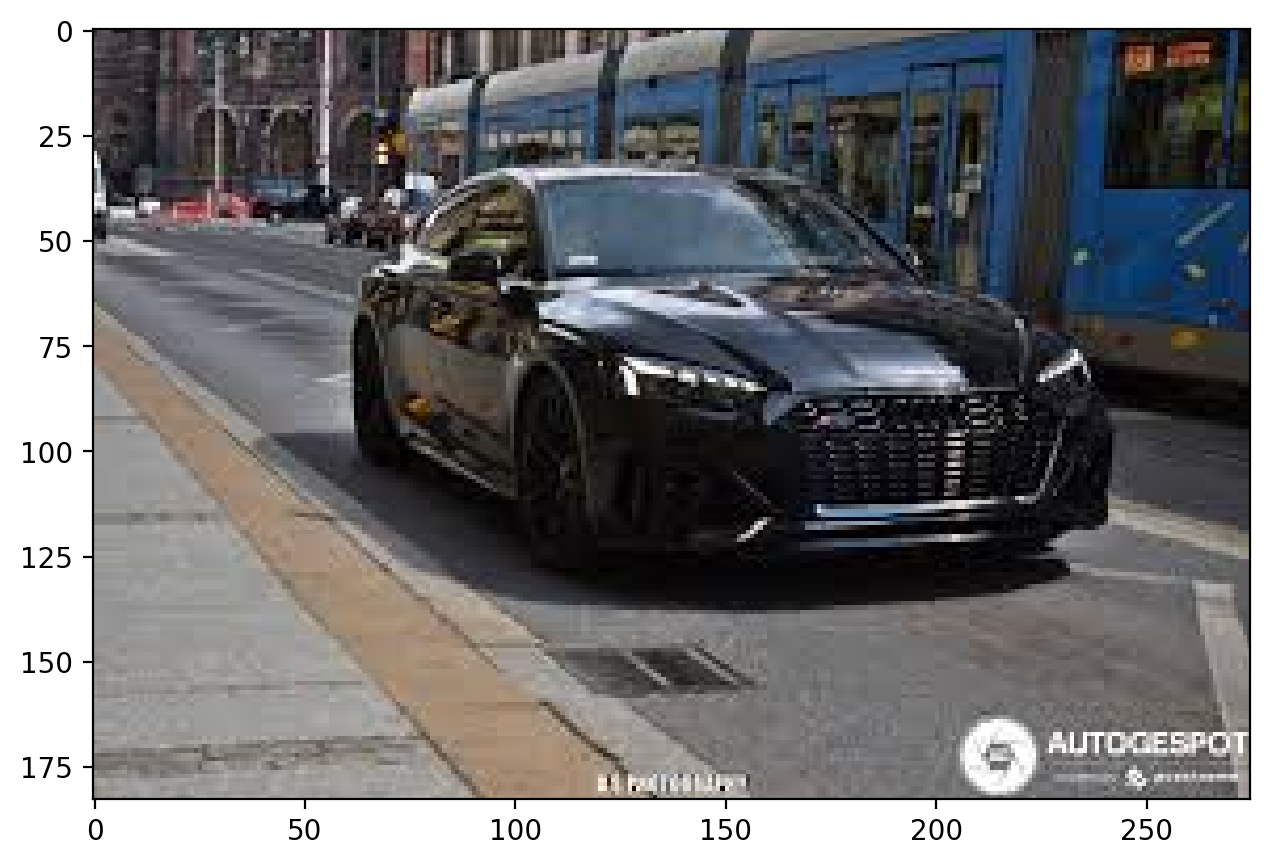

In [10]:
plt.figure(figsize=(16, 5), dpi=200)
plt.imshow(img)
plt.show()

In [11]:
img_gray = img.convert('L')

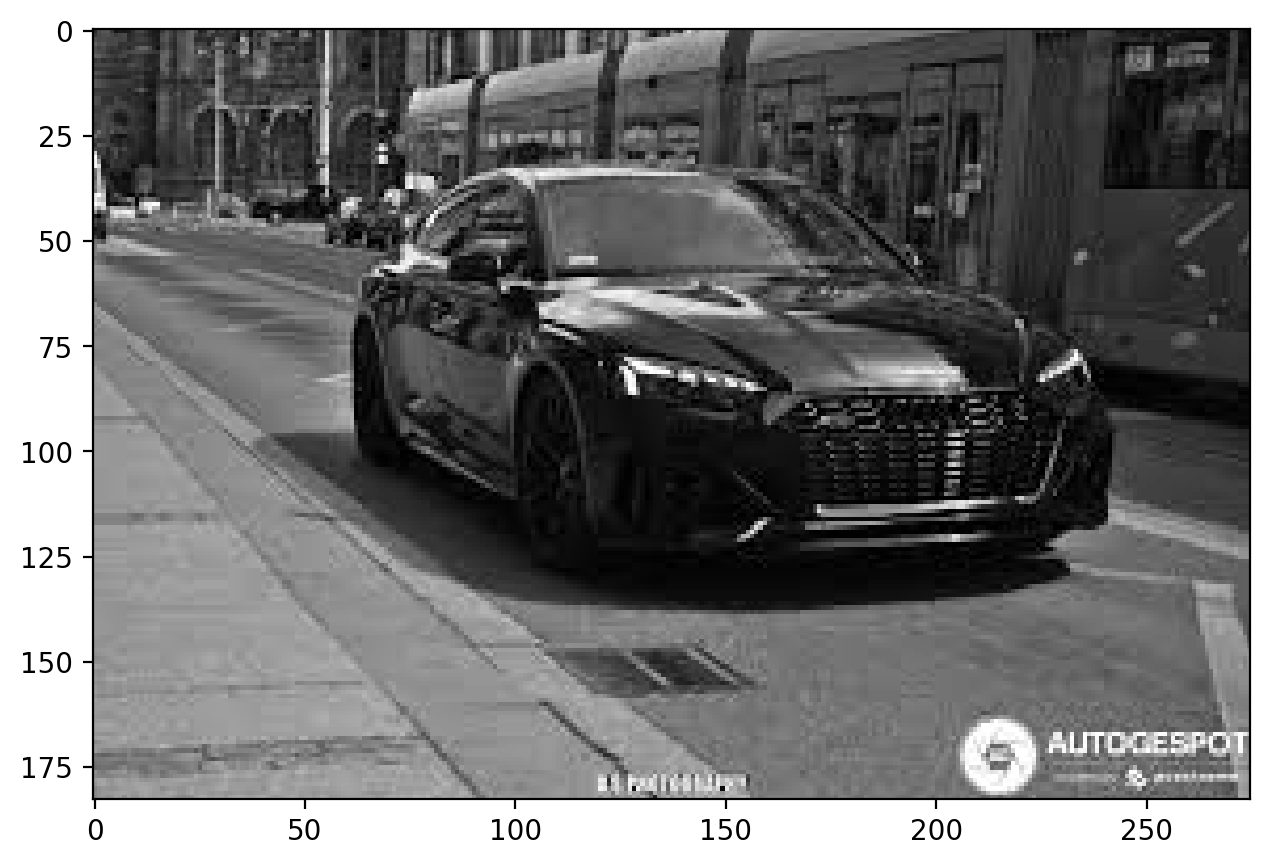

In [13]:
plt.figure(figsize=(16, 5), dpi=200)
plt.imshow(img_gray, cmap="gray")
plt.show()

In [17]:
img_resized = img_gray.resize((128, 64)) # (width, height)

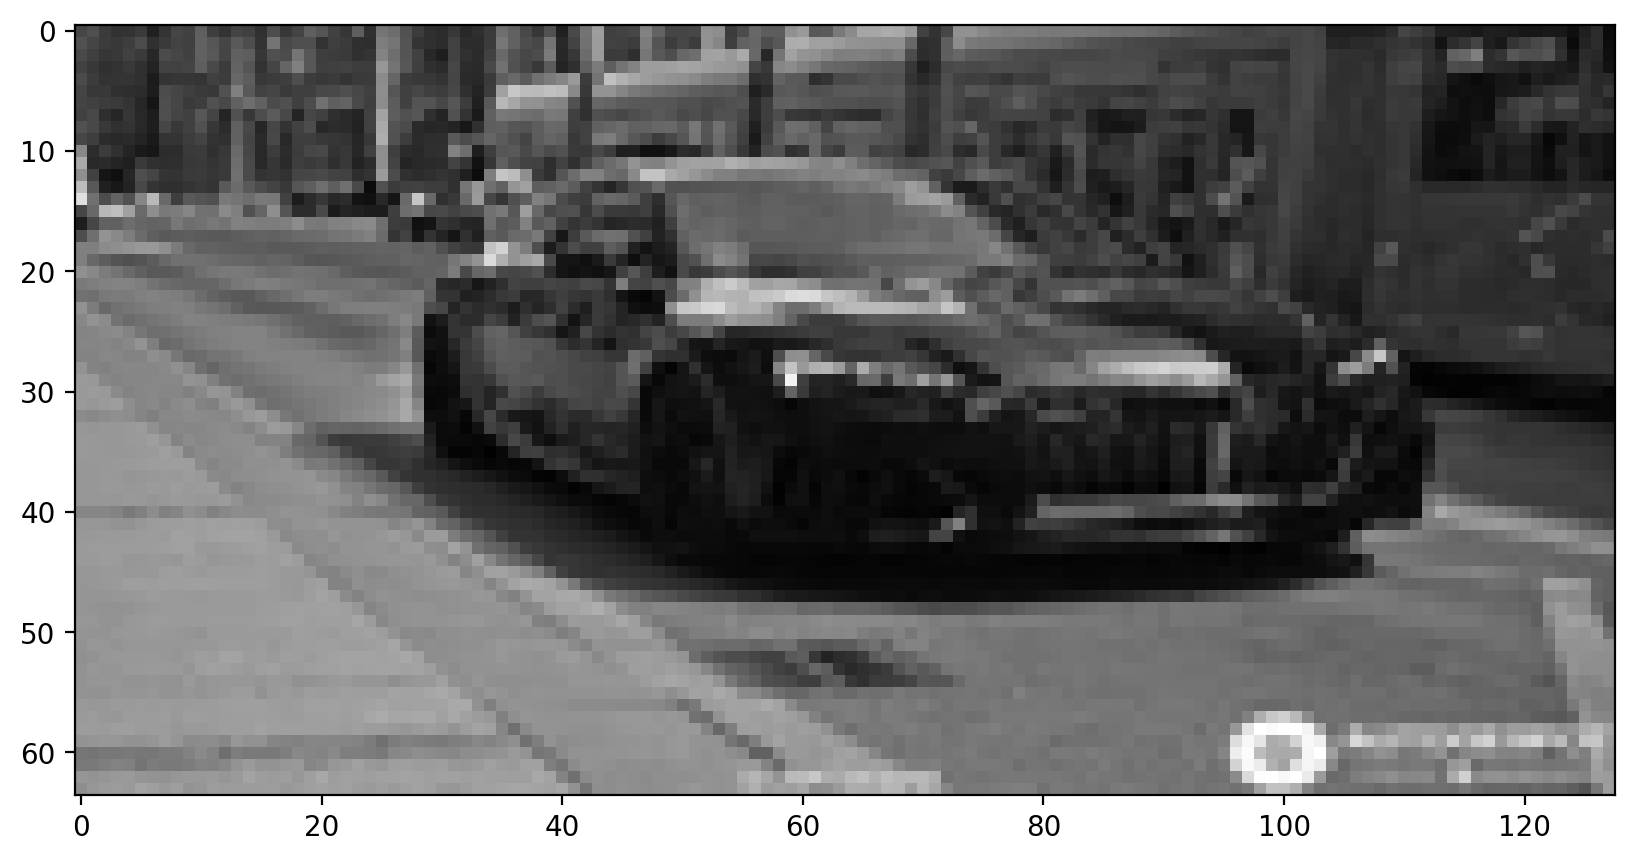

In [18]:
plt.figure(figsize=(16, 5), dpi=200)
plt.imshow(img_resized, cmap="gray")
plt.show()

In [19]:
img_arr = np.array(img_resized)

In [20]:
img_arr.shape

(64, 128)

**Calculate gradients**

In [25]:
img_arr[5, 5]

45.0

In [26]:
G_x = img_arr[5, 6] - img_arr[5, 4]
G_y = img_arr[6, 5] - img_arr[4, 5]

G_x, G_y

(-17.0, -10.0)